# Openmc Overview

The purpose of this notebook is to provide an introduction to the capabilities of OpenMC.  The coverage is intended to provide a fairly deep look at a geometrically simple problem of an infinite pin-cell. The basic topics to be covered will be:

1. material specification
2. geometry description
3. tally specification
4. control parameter specification

The analysis will include a simple criticality calculation and neutron flux energy spectrum measurement.  This will be followed by a somewhat more elaborate treatment of fuel material specification and some exploration into the consequences of one or two important details of fuel material composition.  A burn-up analysis will also be conducted to demonstrate the code capabilities and get a first look at the evolution of important fission products.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import math
import openmc

## Material Specification

First we will define the fuel

In [2]:
fuel = openmc.Material(name="uo2")
fuel.add_element("U",1,percent_type="ao", enrichment=4.25,enrichment_type='wo')
fuel.add_element("O",2)
fuel.set_density("g/cc",10.4)

Documentation on the OpenMC Material object, along with all other OpenMC features can be found [here](https://docs.openmc.org/en/stable/)

Next we define the cladding

In [3]:
clad = openmc.Material(name='clad')
clad.add_element("Zr",1)
clad.set_density('g/cc',6.0)

and water moderator.

In [4]:
water = openmc.Material(name='water')
water.add_element('O',1)
water.add_element('H',2)
water.set_density('g/cc',1.0)
water.add_s_alpha_beta('c_H_in_H2O')

The last line adds some additional physics.  The kinematics of neutron scattering interactions depends on whether the target atom is *free* or *bound in a molecule*.  This dependence is stronger for light atoms.  The required modification to scattering interactions is captured in, so called, $S(\alpha,\beta)$ relation.  In the code block above we "add" the $S(\alpha,\beta)$ relation for hydrogen bound in water.

Any time you have a significant atom fraction of light atoms bound in molecules you should be looking to add an appropriate $S(\alpha,\beta)$.

These are all of the materials that we are going to include for this simple model.  In order for the OpenMC neutron transport code to use the materials, they need to be written to an XML file called 'materials.xml'. The OpenMC Python interface provides tools for doing this in the `Materials` object.

In [5]:
materials = openmc.Materials()
materials += [fuel, clad, water]
materials.export_to_xml()

## Geometry

Next we will define the geometry.  As a first example we will create an infinite array of infinitely long pin cells.

The geometry definition process we will follow for this example will comprise these steps:

1. Definition of surfaces (in some cases including boundary conditions)
2. Definition of regions which are collections of half-spaces
3. Definition of cells which combines half-spaces with materials; and
4. Organization of cells into a universe.


### Surface Definitions

In [6]:
R_fo = 0.39 # cm, fuel outer radius
R_ci = 0.40 # cm, clad inner radius
R_co = 0.46 # cm, clad outer radius
Pitch = 1.26 # cm, distance between centerline of adjacent cells

fuel_outer_radius = openmc.ZCylinder(r=R_fo)
clad_inner_radius = openmc.ZCylinder(r=R_ci)
clad_outer_radius = openmc.ZCylinder(r=R_co)

left = openmc.XPlane(x0=-Pitch/2., boundary_type='reflective')
right = openmc.XPlane(x0=Pitch/2., boundary_type='reflective')
bottom = openmc.YPlane(y0=-Pitch/2., boundary_type='reflective')
top = openmc.YPlane(y0=Pitch/2., boundary_type='reflective')

### Definition of Regions

In [7]:
fuel_region = -fuel_outer_radius
gap_region = +fuel_outer_radius & -clad_inner_radius
clad_region = +clad_inner_radius & -clad_outer_radius

water_region = +left & -right & +bottom & -top & +clad_outer_radius

### Definition of Cells

In [8]:
fuel_cell = openmc.Cell(name='fuel')
fuel_cell.fill = fuel
fuel_cell.region = fuel_region

gap_cell = openmc.Cell(name='gap')
gap_cell.region = gap_region
gap_cell.fill = None # no material = void

clad_cell = openmc.Cell(name='clad')
clad_cell.region = clad_region
clad_cell.fill = clad

water_cell = openmc.Cell(name='moderator')
water_cell.region = water_region
water_cell.fill = water



### Definition of a Universe

In [9]:
root_universe = openmc.Universe(cells=(fuel_cell,gap_cell,clad_cell,water_cell))

geometry = openmc.Geometry()
geometry.root_universe = root_universe
geometry.export_to_xml()

### Plot the Geometry

In [10]:
colors = {}
colors[fuel] = 'yellow'
colors[clad] = 'grey'
colors[water] = 'blue'

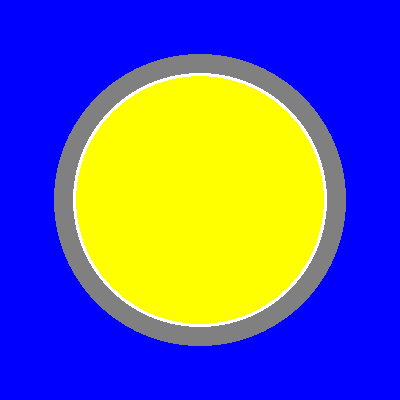

In [11]:
p = openmc.Plot()
p.width = [Pitch,Pitch]
p.pixels = [400,400]
p.origin = [0.0, 0.0, 0.0]
p.color_by = 'material'
p.colors = colors

openmc.plot_inline(p)


Now that the geometry and material composition of the reactor is specified, we need to tell OpenMC what information we hope to get out of the model.  This is done through *tallies*.

### Re-do Geometry with a Finite Pincell

In [12]:
h_core = 300.; 
h_fuel = 200.;

r_fuel = 0.42;
r_pin = 0.45;

P_D = 1.4;

pitch = P_D*2*r_pin;

fuel_temp = 900; # K, guess at fuel temperature
mod_temp = 600; # K, moderator temperature

# fuel cylinder:
fuel_cyl = openmc.model.RightCircularCylinder([0.,0.,-h_fuel/2.],
                                             h_fuel, r_fuel);

fuel.volume = np.pi*(r_fuel**2)*h_fuel;

# pin cylinder
pin_cyl = openmc.model.RightCircularCylinder([0.,0.,-(h_fuel+(r_pin-r_fuel))/2.],
                                            h_fuel+(r_pin-r_fuel)*2.,r_pin);

# pin cell container
core_cell = openmc.model.RectangularParallelepiped(-pitch/2.,pitch/2.,
                                                  -pitch/2.,pitch/2.,
                                                  -h_core/2.,h_core/2.,
                                                  boundary_type='reflective');

fuel_cell = openmc.Cell();
fuel_cell.region = -fuel_cyl
fuel_cell.fill = fuel;
fuel_cell.temperature = fuel_temp;


clad_cell = openmc.Cell();
clad_cell.region = +fuel_cyl & -pin_cyl;
clad_cell.fill = clad;

mod_cell = openmc.Cell();
mod_cell.region = +pin_cyl & -core_cell;
mod_cell.fill = water

root_univ = openmc.Universe();
root_univ.add_cells([fuel_cell,clad_cell,mod_cell]);

geometry = openmc.Geometry();
geometry.root_universe = root_univ;

materials.export_to_xml();
geometry.export_to_xml();


## Tally Specification

In [13]:
# flux energy spectrum in fuel cell
cell_filter = openmc.CellFilter(fuel_cell)

energy_bins = np.logspace(-3,7,num=1001)
energy_filter = openmc.EnergyFilter(values=energy_bins)

flux_tally = openmc.Tally(name='flux')
flux_tally.scores = ['flux']
flux_tally.filters = [cell_filter,energy_filter]


tallies = openmc.Tallies([flux_tally])

tallies.export_to_xml()

## Settings

In [14]:
settings = openmc.Settings()
settings.batches = 300
settings.inactive = 50
settings.particles = 20000

point = openmc.stats.Point((0,0,0))
source = openmc.Source(space=point)

settings.source = source

settings.export_to_xml()

In [15]:
import os

num_threads_des = 12  # set as desired.  Can be useful to ensure you do not take over all the resources for a machine
num_threads = min(os.cpu_count(),num_threads_des); # prevent asking for more threads than OMP_NUM_THREADS

openmc.run(threads = num_threads)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      137/1    1.42577    1.43811 +/- 0.00130
      138/1    1.43196    1.43804 +/- 0.00129
      139/1    1.45369    1.43822 +/- 0.00128
      140/1    1.42018    1.43802 +/- 0.00129
      141/1    1.43384    1.43797 +/- 0.00127
      142/1    1.42732    1.43786 +/- 0.00126
      143/1    1.45958    1.43809 +/- 0.00127
      144/1    1.44053    1.43812 +/- 0.00126
      145/1    1.44397    1.43818 +/- 0.00125
      146/1    1.44422    1.43824 +/- 0.00124
      147/1    1.45192    1.43838 +/- 0.00123
      148/1    1.43275    1.43833 +/- 0.00122
      149/1    1.42514    1.43819 +/- 0.00121
      150/1    1.41707    1.43798 +/- 0.00122
      151/1    1.40226    1.43763 +/- 0.00126
      152/1    1.45431    1.43779 +/- 0.00126
      153/1    1.42732    1.43769 +/- 0.00125
      154/1    1.42980    1.43761 +/- 0.00124
      155/1    1.44908    1.43772 +/- 0.00123
      156/1    1.43059    1.43765 +/- 0.00122
      157/1    1.42394    1.43753 +/- 0.00122
      158/1    1.43665    1.43752 

### Access Tally and Plot Flux Spectrum

In [16]:
sp = openmc.StatePoint('statepoint.300.h5')
sp.tallies

{1: Tally
 	ID             =	1
 	Name           =	flux
 	Filters        =	CellFilter, EnergyFilter
 	Nuclides       =	total
 	Scores         =	['flux']
 	Estimator      =	tracklength}

Text(0, 0.5, 'flux [n/cm**2-s]')

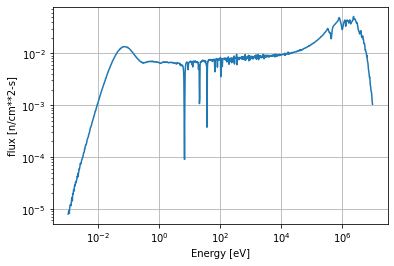

In [17]:
flux = sp.get_tally(name='flux')
flux_df = flux.get_pandas_dataframe()
flux_vals = flux_df['mean'].to_numpy()

energy_x = 0.5*(energy_bins[0:-1]+energy_bins[1:])

plt.loglog(energy_x,flux_vals)
plt.grid()
plt.xlabel('Energy [eV]')
plt.ylabel('flux [n/cm**2-s]')


Notice the deep "pits" in the flux energy distribution.  It is worthwhile to investigate why those features exist.  To do so, more tallies could be added; specifically to measure capture - in total, as well as by specific isotopes. 

In [18]:
sp.close()

## Bonu Section: Depletion

In [19]:
import openmc.deplete

chain = openmc.deplete.Chain.from_xml("chain_endfb71_pwr.xml")


In [20]:
chain.nuclide_dict

OrderedDict([('H1', 0),
             ('H2', 1),
             ('H3', 2),
             ('H4', 3),
             ('H5', 4),
             ('H6', 5),
             ('H7', 6),
             ('He3', 7),
             ('He4', 8),
             ('He5', 9),
             ('He6', 10),
             ('He7', 11),
             ('He8', 12),
             ('He9', 13),
             ('He10', 14),
             ('Li4', 15),
             ('Li5', 16),
             ('Li6', 17),
             ('Li7', 18),
             ('Li8', 19),
             ('Li9', 20),
             ('Li10', 21),
             ('Li11', 22),
             ('Li12', 23),
             ('Be5', 24),
             ('Be6', 25),
             ('Be8', 26),
             ('Be9', 27),
             ('Be10', 28),
             ('Be11', 29),
             ('Be12', 30),
             ('Be13', 31),
             ('Be14', 32),
             ('Be15', 33),
             ('Be16', 34),
             ('B6', 35),
             ('B7', 36),
             ('B8', 37),
             ('B9', 3

In [21]:
# starting with version 0.13.0, the first argument to an Operator object needs to be a Model
model = openmc.model.Model(geometry, materials, settings);

operator = openmc.deplete.Operator(model,"chain_endfb71_pwr.xml")

power = 1e4;
days = 24*3600; # number of seconds in a day

time_steps = [0.1*days, 0.1*days, 0.1*days, 1.*days, 30*days, 30*days, 180*days]

integrator = openmc.deplete.PredictorIntegrator(operator,time_steps,power)

integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Mg24 from /home/sblair/OMC_DATA/endfb71_hdf5/Mg24.h5
 Reading Mg25 from /home/sblair/OMC_DATA/endfb71_hdf5/Mg25.h5
 Reading Mg26 from /home/sblair/OMC_DATA/endfb71_hdf5/Mg26.h5
 Reading Al27 from /home/sblair/OMC_DATA/endfb71_hdf5/Al27.h5
 Reading Si28 from /home/sblair/OMC_DATA/endfb71_hdf5/Si28.h5
 Reading Si29 from /home/sblair/OMC_DATA/endfb71_hdf5/Si29.h5
 Reading Si30 from /home/sblair/OMC_DATA/endfb71_hdf5/Si30.h5
 Reading P31 from /home/sblair/OMC_DATA/endfb71_hdf5/P31.h5
 Reading S32 from /home/sblair/OMC_DATA/endfb71_hdf5/S32.h5
 Reading S33 from /home/sblair/OMC_DATA/endfb71_hdf5/S33.h5
 Reading S34 from /home/sblair/OMC_DATA/endfb71_hdf5/S34.h5
 Reading S36 from /home/sblair/OMC_DATA/endfb71_hdf5/S36.h5
 Reading Cl35 from /home/sblair/OMC_DATA/endfb71_hdf5/Cl35.h5
 Reading Cl37 from /home/sblair/OMC_DATA/endfb71_hdf5/Cl37.h5
 Reading Ar36 from /home/sblair/OMC_DATA/endfb71_hdf5/Ar36.h5
 Reading Ar38 from /home/sblair/OMC_DATA/endfb71_hdf5/Ar38.h5
 Reading Ar40 from

 Reading K41 from /home/sblair/OMC_DATA/endfb71_hdf5/K41.h5
 Reading Ca40 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca40.h5
 Reading Ca42 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca42.h5
 Reading Ca43 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca43.h5
 Reading Ca44 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca44.h5
 Reading Ca46 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca46.h5
 Reading Ca48 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca48.h5
 Reading Sc45 from /home/sblair/OMC_DATA/endfb71_hdf5/Sc45.h5
 Reading Ti46 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti46.h5
 Reading Ti47 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti47.h5
 Reading Ti48 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti48.h5
 Reading Ti49 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti49.h5
 Reading Ti50 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti50.h5
 Reading V50 from /home/sblair/OMC_DATA/endfb71_hdf5/V50.h5
 Reading V51 from /home/sblair/OMC_DATA/endfb71_hdf5/V51.h5
 Reading Cr50 from /home/sblair/OMC_DATA/endfb71_hdf5/Cr50.h5
 Reading Cr52 

 Reading Br81 from /home/sblair/OMC_DATA/endfb71_hdf5/Br81.h5
 Reading Kr78 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr78.h5
 Reading Kr80 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr80.h5
 Reading Kr82 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr82.h5
 Reading Kr83 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr83.h5
 Reading Kr84 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr84.h5
 Reading Kr85 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr85.h5
 Reading Kr86 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr86.h5
 Reading Rb85 from /home/sblair/OMC_DATA/endfb71_hdf5/Rb85.h5
 Reading Rb86 from /home/sblair/OMC_DATA/endfb71_hdf5/Rb86.h5
 Reading Rb87 from /home/sblair/OMC_DATA/endfb71_hdf5/Rb87.h5
 Reading Sr84 from /home/sblair/OMC_DATA/endfb71_hdf5/Sr84.h5
 Reading Sr86 from /home/sblair/OMC_DATA/endfb71_hdf5/Sr86.h5
 Reading Sr87 from /home/sblair/OMC_DATA/endfb71_hdf5/Sr87.h5
 Reading Sr88 from /home/sblair/OMC_DATA/endfb71_hdf5/Sr88.h5
 Reading Sr89 from /home/sblair/OMC_DATA/endfb71_hdf5/Sr89.h5
 Reading

 Reading Nb95 from /home/sblair/OMC_DATA/endfb71_hdf5/Nb95.h5
 Reading Mo92 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo92.h5
 Reading Mo94 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo94.h5
 Reading Mo95 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo95.h5
 Reading Mo96 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo96.h5
 Reading Mo97 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo97.h5
 Reading Mo98 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo98.h5
 Reading Mo99 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo99.h5


 Reading Mo100 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo100.h5
 Reading Tc99 from /home/sblair/OMC_DATA/endfb71_hdf5/Tc99.h5
 Reading Ru96 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru96.h5
 Reading Ru98 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru98.h5
 Reading Ru99 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru99.h5
 Reading Ru100 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru100.h5
 Reading Ru101 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru101.h5
 Reading Ru102 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru102.h5
 Reading Ru103 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru103.h5
 Reading Ru104 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru104.h5
 Reading Ru105 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru105.h5
 Reading Ru106 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru106.h5
 Reading Rh103 from /home/sblair/OMC_DATA/endfb71_hdf5/Rh103.h5
 Reading Rh105 from /home/sblair/OMC_DATA/endfb71_hdf5/Rh105.h5
 Reading Pd102 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd102.h5
 Reading Pd104 from /home/sblair/OMC_DATA/endfb7

          1200K
          2500K


 Reading Cd108 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd108.h5
 Reading Cd110 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd110.h5
 Reading Cd111 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd111.h5
 Reading Cd112 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd112.h5
 Reading Cd113 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd113.h5
 Reading Cd114 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd114.h5
 Reading Cd115_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd115_m1.h5
 Reading Cd116 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd116.h5
 Reading In113 from /home/sblair/OMC_DATA/endfb71_hdf5/In113.h5
 Reading In115 from /home/sblair/OMC_DATA/endfb71_hdf5/In115.h5
 Reading Sn112 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn112.h5
 Reading Sn113 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn113.h5
 Reading Sn114 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn114.h5
 Reading Sn115 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn115.h5
 Reading Sn116 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn116.h5
 Reading Sn117 from /home/sblair/O

          1200K
          2500K


 Reading Sn125 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn125.h5
 Reading Sn126 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn126.h5
 Reading Sb121 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb121.h5
 Reading Sb123 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb123.h5
 Reading Sb124 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb124.h5
 Reading Sb125 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb125.h5
 Reading Sb126 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb126.h5
 Reading Te120 from /home/sblair/OMC_DATA/endfb71_hdf5/Te120.h5
 Reading Te122 from /home/sblair/OMC_DATA/endfb71_hdf5/Te122.h5


          1200K
          2500K


 Reading Te123 from /home/sblair/OMC_DATA/endfb71_hdf5/Te123.h5
 Reading Te124 from /home/sblair/OMC_DATA/endfb71_hdf5/Te124.h5
 Reading Te125 from /home/sblair/OMC_DATA/endfb71_hdf5/Te125.h5
 Reading Te126 from /home/sblair/OMC_DATA/endfb71_hdf5/Te126.h5
 Reading Te127_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Te127_m1.h5
 Reading Te128 from /home/sblair/OMC_DATA/endfb71_hdf5/Te128.h5
 Reading Te129_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Te129_m1.h5
 Reading Te130 from /home/sblair/OMC_DATA/endfb71_hdf5/Te130.h5
 Reading Te132 from /home/sblair/OMC_DATA/endfb71_hdf5/Te132.h5
 Reading I127 from /home/sblair/OMC_DATA/endfb71_hdf5/I127.h5
 Reading I129 from /home/sblair/OMC_DATA/endfb71_hdf5/I129.h5
 Reading I130 from /home/sblair/OMC_DATA/endfb71_hdf5/I130.h5
 Reading I131 from /home/sblair/OMC_DATA/endfb71_hdf5/I131.h5
 Reading I135 from /home/sblair/OMC_DATA/endfb71_hdf5/I135.h5
 Reading Xe123 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe123.h5


 Reading Xe124 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe124.h5
 Reading Xe126 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe126.h5
 Reading Xe128 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe128.h5
 Reading Xe129 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe129.h5
 Reading Xe130 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe130.h5
 Reading Xe131 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe131.h5
 Reading Xe132 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe132.h5
 Reading Xe133 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe133.h5
 Reading Xe134 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe134.h5
 Reading Xe135 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe135.h5
 Reading Xe136 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe136.h5
 Reading Cs133 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs133.h5


          2500K


 Reading Cs134 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs134.h5
 Reading Cs135 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs135.h5
 Reading Cs136 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs136.h5
 Reading Cs137 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs137.h5
 Reading Ba130 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba130.h5
 Reading Ba132 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba132.h5


          1200K
          2500K


 Reading Ba133 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba133.h5
 Reading Ba134 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba134.h5
 Reading Ba135 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba135.h5
 Reading Ba136 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba136.h5
 Reading Ba137 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba137.h5
 Reading Ba138 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba138.h5
 Reading Ba140 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba140.h5
 Reading La138 from /home/sblair/OMC_DATA/endfb71_hdf5/La138.h5
 Reading La139 from /home/sblair/OMC_DATA/endfb71_hdf5/La139.h5
 Reading La140 from /home/sblair/OMC_DATA/endfb71_hdf5/La140.h5
 Reading Ce136 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce136.h5
 Reading Ce138 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce138.h5
 Reading Ce139 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce139.h5
 Reading Ce140 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce140.h5
 Reading Ce141 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce141.h5
 Reading Ce142 from /home/sblair/OMC_DAT

          1200K
          2500K


 Reading Gd152 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd152.h5
 Reading Gd153 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd153.h5
 Reading Gd154 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd154.h5
 Reading Gd155 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd155.h5
 Reading Gd156 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd156.h5
 Reading Gd157 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd157.h5
 Reading Gd158 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd158.h5
 Reading Gd160 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd160.h5
 Reading Tb159 from /home/sblair/OMC_DATA/endfb71_hdf5/Tb159.h5
 Reading Tb160 from /home/sblair/OMC_DATA/endfb71_hdf5/Tb160.h5
 Reading Dy156 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy156.h5
 Reading Dy158 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy158.h5
 Reading Dy160 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy160.h5
 Reading Dy161 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy161.h5
 Reading Dy162 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy162.h5
 Reading Dy163 from /home/sblair/OMC_DAT

 Reading Cf250 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf250.h5
 Reading Cf251 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf251.h5
 Reading Cf252 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf252.h5
 Reading Cf253 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf253.h5
 Reading Cf254 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf254.h5
 Reading Es251 from /home/sblair/OMC_DATA/endfb71_hdf5/Es251.h5


          1200K


 Reading Es252 from /home/sblair/OMC_DATA/endfb71_hdf5/Es252.h5
 Reading Es253 from /home/sblair/OMC_DATA/endfb71_hdf5/Es253.h5
 Reading Es254 from /home/sblair/OMC_DATA/endfb71_hdf5/Es254.h5
 Reading Es254_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Es254_m1.h5
 Reading Es255 from /home/sblair/OMC_DATA/endfb71_hdf5/Es255.h5
 Reading Fm255 from /home/sblair/OMC_DATA/endfb71_hdf5/Fm255.h5
 Maximum neutron transport energy: 20000000 eV for O17
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.45268
        2/1    1.45343
        3/1    1.44926
        4/1    1.44696
        5/1    1.46211
        6/1    1.46581
        7/1    1.45974
        8/1    1.43240
        9/1    1.43882
       10/1    1.44751
       11/1    1.47282
       12/1    1.44570
       13/1    1.45841
       14/1    1.44290
       15/1    1.45317
       16/1

      191/1    1.44951    1.43756 +/- 0.00109
      192/1    1.42534    1.43748 +/- 0.00109
      193/1    1.43478    1.43746 +/- 0.00108
      194/1    1.44386    1.43750 +/- 0.00108
      195/1    1.41981    1.43738 +/- 0.00108
      196/1    1.42701    1.43731 +/- 0.00107
      197/1    1.45023    1.43740 +/- 0.00107
      198/1    1.42509    1.43732 +/- 0.00106
      199/1    1.45821    1.43746 +/- 0.00106
      200/1    1.43888    1.43746 +/- 0.00106
      201/1    1.42609    1.43739 +/- 0.00105
      202/1    1.45300    1.43749 +/- 0.00105
      203/1    1.41766    1.43736 +/- 0.00105
      204/1    1.42550    1.43729 +/- 0.00105
      205/1    1.45388    1.43739 +/- 0.00105
      206/1    1.42002    1.43728 +/- 0.00105
      207/1    1.45749    1.43741 +/- 0.00105
      208/1    1.43576    1.43740 +/- 0.00104
      209/1    1.43872    1.43741 +/- 0.00103
      210/1    1.43278    1.43738 +/- 0.00103
      211/1    1.43902    1.43739 +/- 0.00102
      212/1    1.43852    1.43740 

       60/1    1.43873    1.44135 +/- 0.00467
       61/1    1.43471    1.44075 +/- 0.00427
       62/1    1.44150    1.44081 +/- 0.00390
       63/1    1.44296    1.44097 +/- 0.00359
       64/1    1.44462    1.44124 +/- 0.00333
       65/1    1.44993    1.44181 +/- 0.00316
       66/1    1.44791    1.44220 +/- 0.00298
       67/1    1.43399    1.44171 +/- 0.00284
       68/1    1.41837    1.44042 +/- 0.00297
       69/1    1.43983    1.44039 +/- 0.00281
       70/1    1.45942    1.44134 +/- 0.00283
       71/1    1.43231    1.44091 +/- 0.00273
       72/1    1.44129    1.44092 +/- 0.00260
       73/1    1.44202    1.44097 +/- 0.00249
       74/1    1.41577    1.43992 +/- 0.00260
       75/1    1.42553    1.43935 +/- 0.00256
       76/1    1.44168    1.43944 +/- 0.00246
       77/1    1.44387    1.43960 +/- 0.00238
       78/1    1.44983    1.43997 +/- 0.00232
       79/1    1.45327    1.44042 +/- 0.00228
       80/1    1.43971    1.44040 +/- 0.00221
       81/1    1.43649    1.44027 

      239/1    1.42338    1.43770 +/- 0.00087
      240/1    1.43660    1.43769 +/- 0.00086
      241/1    1.43695    1.43769 +/- 0.00086
      242/1    1.43552    1.43768 +/- 0.00085
      243/1    1.41166    1.43754 +/- 0.00086
      244/1    1.42602    1.43749 +/- 0.00086
      245/1    1.41527    1.43737 +/- 0.00086
      246/1    1.43305    1.43735 +/- 0.00086
      247/1    1.45137    1.43742 +/- 0.00086
      248/1    1.45069    1.43749 +/- 0.00085
      249/1    1.42486    1.43742 +/- 0.00085
      250/1    1.45094    1.43749 +/- 0.00085
      251/1    1.43269    1.43747 +/- 0.00085
      252/1    1.43222    1.43744 +/- 0.00084
      253/1    1.45306    1.43752 +/- 0.00084
      254/1    1.44358    1.43755 +/- 0.00084
      255/1    1.43643    1.43754 +/- 0.00083
      256/1    1.42415    1.43748 +/- 0.00083
      257/1    1.43821    1.43748 +/- 0.00083
      258/1    1.43410    1.43747 +/- 0.00083
      259/1    1.43259    1.43744 +/- 0.00082
      260/1    1.45661    1.43753 

      108/1    1.42781    1.43388 +/- 0.00158
      109/1    1.46220    1.43436 +/- 0.00162
      110/1    1.42772    1.43425 +/- 0.00160
      111/1    1.42018    1.43402 +/- 0.00159
      112/1    1.43236    1.43399 +/- 0.00156
      113/1    1.43439    1.43400 +/- 0.00154
      114/1    1.43288    1.43398 +/- 0.00151
      115/1    1.44756    1.43419 +/- 0.00150
      116/1    1.42468    1.43405 +/- 0.00149
      117/1    1.43284    1.43403 +/- 0.00147
      118/1    1.43436    1.43403 +/- 0.00144
      119/1    1.43664    1.43407 +/- 0.00142
      120/1    1.44619    1.43425 +/- 0.00141
      121/1    1.43572    1.43427 +/- 0.00139
      122/1    1.42279    1.43411 +/- 0.00138
      123/1    1.41749    1.43388 +/- 0.00138
      124/1    1.43497    1.43389 +/- 0.00137
      125/1    1.42575    1.43379 +/- 0.00135
      126/1    1.43424    1.43379 +/- 0.00133
      127/1    1.43805    1.43385 +/- 0.00132
      128/1    1.44721    1.43402 +/- 0.00131
      129/1    1.45206    1.43425 

      287/1    1.45804    1.43568 +/- 0.00077
      288/1    1.42879    1.43565 +/- 0.00076
      289/1    1.44500    1.43569 +/- 0.00076
      290/1    1.43383    1.43568 +/- 0.00076
      291/1    1.44554    1.43573 +/- 0.00076
      292/1    1.41122    1.43562 +/- 0.00076
      293/1    1.42104    1.43556 +/- 0.00076
      294/1    1.41246    1.43547 +/- 0.00076
      295/1    1.45850    1.43556 +/- 0.00077
      296/1    1.43341    1.43555 +/- 0.00076
      297/1    1.44253    1.43558 +/- 0.00076
      298/1    1.43295    1.43557 +/- 0.00076
      299/1    1.44090    1.43559 +/- 0.00075
      300/1    1.42856    1.43557 +/- 0.00075
 Creating state point statepoint.300.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 8.9463e+02 seconds
   Time in transport only          = 8.9336e+02 seconds
   Time in

      156/1    1.42704    1.43233 +/- 0.00124
      157/1    1.43131    1.43232 +/- 0.00123
      158/1    1.43572    1.43235 +/- 0.00121
      159/1    1.45041    1.43252 +/- 0.00121
      160/1    1.42331    1.43243 +/- 0.00121
      161/1    1.44660    1.43256 +/- 0.00120
      162/1    1.40967    1.43235 +/- 0.00121
      163/1    1.44709    1.43249 +/- 0.00121
      164/1    1.44052    1.43256 +/- 0.00120
      165/1    1.44018    1.43262 +/- 0.00119
      166/1    1.43296    1.43262 +/- 0.00118
      167/1    1.42987    1.43260 +/- 0.00117
      168/1    1.44088    1.43267 +/- 0.00116
      169/1    1.44829    1.43280 +/- 0.00116
      170/1    1.44266    1.43288 +/- 0.00115
      171/1    1.44942    1.43302 +/- 0.00115
      172/1    1.43983    1.43308 +/- 0.00114
      173/1    1.44001    1.43313 +/- 0.00113
      174/1    1.43234    1.43313 +/- 0.00112
      175/1    1.38830    1.43277 +/- 0.00117
      176/1    1.44233    1.43284 +/- 0.00116
      177/1    1.42553    1.43279 

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.42032
        2/1    1.42273
        3/1    1.43504
        4/1    1.44789
        5/1    1.41619
        6/1    1.43589
        7/1    1.42048
        8/1    1.41846
        9/1    1.43847
       10/1    1.43466
       11/1    1.42129
       12/1    1.42357
       13/1    1.42750
       14/1    1.40072
       15/1    1.43803
       16/1    1.44633
       17/1    1.42369
       18/1    1.42319
       19/1    1.44523
       20/1    1.42892
       21/1    1.42482
       22/1    1.40866
       23/1    1.43309
       24/1    1.42100
       25/1    1.42754
       26/1    1.43173
       27/1    1.42507
       28/1    1.41208
       29/1    1.43433
       30/1    1.41333
       31/1    1.39989
       32/1    1.42911
       33/1    1.41313
       34/1    1.38340
       35/1    1.39701
       36/1    1.40454
       37/1    1.41395
       38/1    1.43574
       39/1    1.41584
       40/1    1.

      203/1    1.40306    1.41509 +/- 0.00104
      204/1    1.39549    1.41496 +/- 0.00104
      205/1    1.43127    1.41506 +/- 0.00104
      206/1    1.42151    1.41510 +/- 0.00103
      207/1    1.42566    1.41517 +/- 0.00103
      208/1    1.44072    1.41533 +/- 0.00103
      209/1    1.41922    1.41536 +/- 0.00103
      210/1    1.42703    1.41543 +/- 0.00102
      211/1    1.40846    1.41539 +/- 0.00102
      212/1    1.41981    1.41541 +/- 0.00101
      213/1    1.41925    1.41544 +/- 0.00100
      214/1    1.40841    1.41540 +/- 0.00100
      215/1    1.43060    1.41549 +/- 0.00100
      216/1    1.42168    1.41552 +/- 0.00099
      217/1    1.43674    1.41565 +/- 0.00099
      218/1    1.41657    1.41566 +/- 0.00099
      219/1    1.41925    1.41568 +/- 0.00098
      220/1    1.41449    1.41567 +/- 0.00098
      221/1    1.41120    1.41565 +/- 0.00097
      222/1    1.42649    1.41571 +/- 0.00097
      223/1    1.40958    1.41567 +/- 0.00096
      224/1    1.40888    1.41563 

       72/1    1.41272    1.41049 +/- 0.00232
       73/1    1.39575    1.40985 +/- 0.00230
       74/1    1.40980    1.40985 +/- 0.00221
       75/1    1.40076    1.40949 +/- 0.00215
       76/1    1.38605    1.40858 +/- 0.00225
       77/1    1.40084    1.40830 +/- 0.00219
       78/1    1.41418    1.40851 +/- 0.00212
       79/1    1.40174    1.40827 +/- 0.00206
       80/1    1.38314    1.40744 +/- 0.00216
       81/1    1.41729    1.40775 +/- 0.00211
       82/1    1.40227    1.40758 +/- 0.00205
       83/1    1.39358    1.40716 +/- 0.00203
       84/1    1.40117    1.40698 +/- 0.00198
       85/1    1.41236    1.40714 +/- 0.00193
       86/1    1.40426    1.40706 +/- 0.00187
       87/1    1.39880    1.40683 +/- 0.00184
       88/1    1.42314    1.40726 +/- 0.00184
       89/1    1.43194    1.40789 +/- 0.00190
       90/1    1.38717    1.40738 +/- 0.00192
       91/1    1.40976    1.40743 +/- 0.00188
       92/1    1.41148    1.40753 +/- 0.00183
       93/1    1.40086    1.40738 

      251/1    1.40459    1.40324 +/- 0.00077
      252/1    1.39959    1.40322 +/- 0.00077
      253/1    1.40027    1.40320 +/- 0.00076
      254/1    1.39567    1.40317 +/- 0.00076
      255/1    1.40780    1.40319 +/- 0.00076
      256/1    1.41359    1.40324 +/- 0.00076
      257/1    1.41434    1.40329 +/- 0.00075
      258/1    1.40710    1.40331 +/- 0.00075
      259/1    1.38543    1.40323 +/- 0.00075
      260/1    1.40123    1.40322 +/- 0.00075
      261/1    1.41868    1.40329 +/- 0.00075
      262/1    1.40749    1.40331 +/- 0.00075
      263/1    1.39103    1.40325 +/- 0.00074
      264/1    1.37768    1.40313 +/- 0.00075
      265/1    1.40936    1.40316 +/- 0.00075
      266/1    1.38825    1.40309 +/- 0.00075
      267/1    1.40735    1.40311 +/- 0.00074
      268/1    1.41062    1.40315 +/- 0.00074
      269/1    1.38609    1.40307 +/- 0.00074
      270/1    1.39825    1.40305 +/- 0.00074
      271/1    1.41066    1.40308 +/- 0.00074
      272/1    1.41616    1.40314 

      120/1    1.39797    1.39498 +/- 0.00153
      121/1    1.40247    1.39508 +/- 0.00152
      122/1    1.41517    1.39536 +/- 0.00152
      123/1    1.37942    1.39514 +/- 0.00152
      124/1    1.40069    1.39522 +/- 0.00150
      125/1    1.40383    1.39533 +/- 0.00148
      126/1    1.40118    1.39541 +/- 0.00146
      127/1    1.40991    1.39560 +/- 0.00146
      128/1    1.39400    1.39558 +/- 0.00144
      129/1    1.38789    1.39548 +/- 0.00142
      130/1    1.38582    1.39536 +/- 0.00141
      131/1    1.38317    1.39521 +/- 0.00140
      132/1    1.41073    1.39540 +/- 0.00140
      133/1    1.39637    1.39541 +/- 0.00138
      134/1    1.39700    1.39543 +/- 0.00136
      135/1    1.38878    1.39535 +/- 0.00135
      136/1    1.38807    1.39527 +/- 0.00134
      137/1    1.40307    1.39536 +/- 0.00132
      138/1    1.38815    1.39527 +/- 0.00131
      139/1    1.39349    1.39525 +/- 0.00130
      140/1    1.38528    1.39514 +/- 0.00129
      141/1    1.37515    1.39492 

      299/1    1.40810    1.39561 +/- 0.00080
      300/1    1.39888    1.39562 +/- 0.00080
 Creating state point statepoint.300.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 8.8941e+02 seconds
   Time in transport only          = 8.8809e+02 seconds
   Time in inactive batches        = 1.1178e+02 seconds
   Time in active batches          = 7.7763e+02 seconds
   Time synchronizing fission bank = 7.8030e-01 seconds
     Sampling source sites         = 6.8660e-01 seconds
     SEND/RECV source sites        = 9.2205e-02 seconds
   Time accumulating tallies       = 1.0658e-01 seconds
   Time writing statepoints        = 1.3996e-02 seconds
 Total time for finalization       = 2.1711e-03 seconds
 Total time elapsed                = 8.8987e+02 seconds
 Calculation Rate (inactive)       = 8945.75 particles/sec

      168/1    1.39496    1.37704 +/- 0.00105
      169/1    1.36665    1.37695 +/- 0.00104
      170/1    1.39369    1.37709 +/- 0.00104
      171/1    1.39828    1.37726 +/- 0.00105
      172/1    1.38214    1.37730 +/- 0.00104
      173/1    1.37904    1.37732 +/- 0.00103
      174/1    1.37884    1.37733 +/- 0.00102
      175/1    1.37844    1.37734 +/- 0.00101
      176/1    1.35788    1.37719 +/- 0.00102
      177/1    1.38773    1.37727 +/- 0.00101
      178/1    1.37436    1.37725 +/- 0.00101
      179/1    1.37652    1.37724 +/- 0.00100
      180/1    1.37785    1.37725 +/- 0.00099
      181/1    1.37293    1.37721 +/- 0.00098
      182/1    1.37704    1.37721 +/- 0.00098
      183/1    1.35265    1.37703 +/- 0.00099
      184/1    1.37670    1.37702 +/- 0.00098
      185/1    1.37738    1.37703 +/- 0.00097
      186/1    1.37392    1.37700 +/- 0.00096
      187/1    1.38587    1.37707 +/- 0.00096
      188/1    1.37587    1.37706 +/- 0.00095
      189/1    1.36895    1.37700 